# **Sequence Modeling and Genome Mining to Discover Virulence Factors in Plant Pathogens**

The constant improvement of whole genome sequencing methodologies has offered important biological information. The databases containing sequences are essential resources for scientists dedicated to studying plant-pathogen interactions and mechanisms of virulence. However, the fast and constant generation of genomic data has created a bottleneck in its analysis. Processes like curation, organization, sharing, and analysis that transform "big data" into "smart data" are moving slowly. In several cases, the scientific community involved in plant-pathogen interaction needs fair access to bioinformatics resources that allow the ideal usage of big genomic data. This workshop aims to train scientists in managing and mining genome data. The workshop will use machine-learning approaches to model biological sequences. We will use a case study to design and implement a pipeline to explore the diversity of effectors in the *Xanthomonas* species. ​

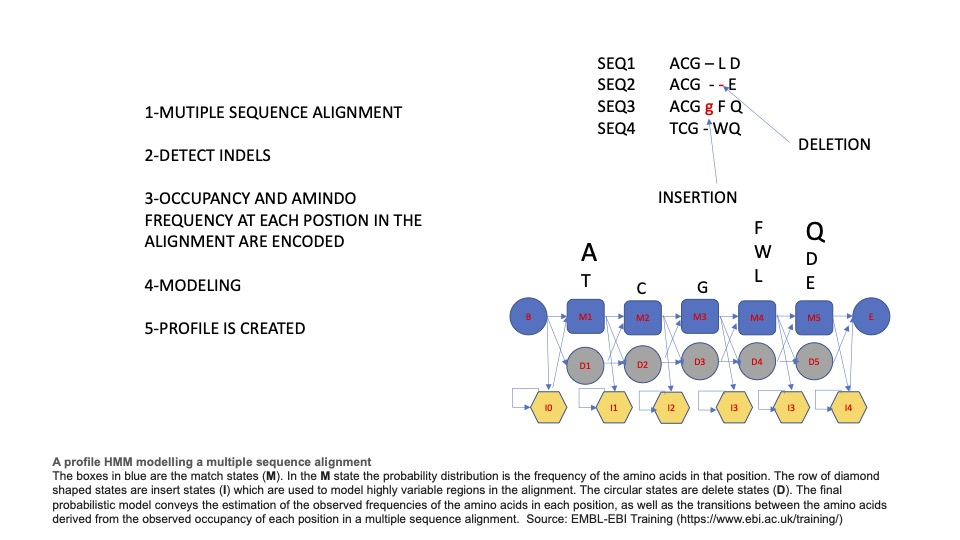

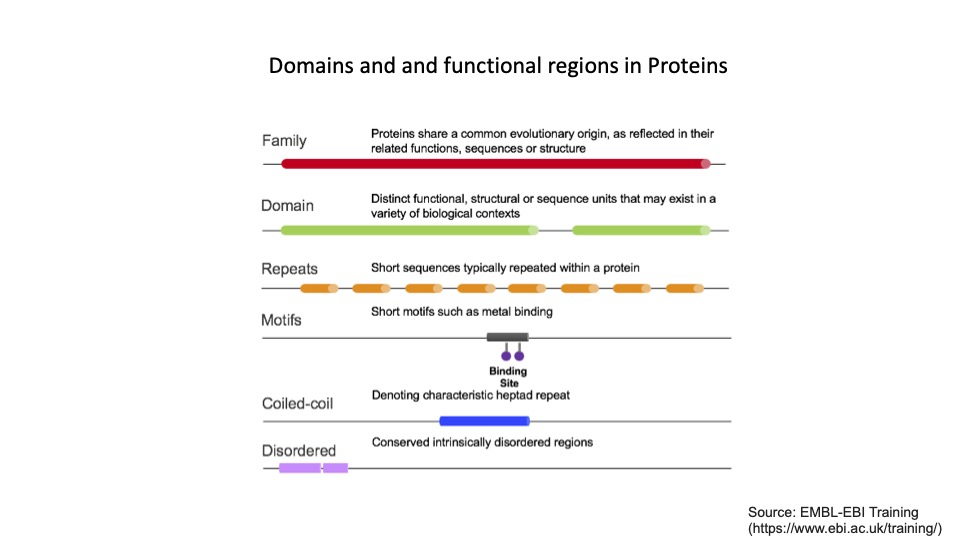

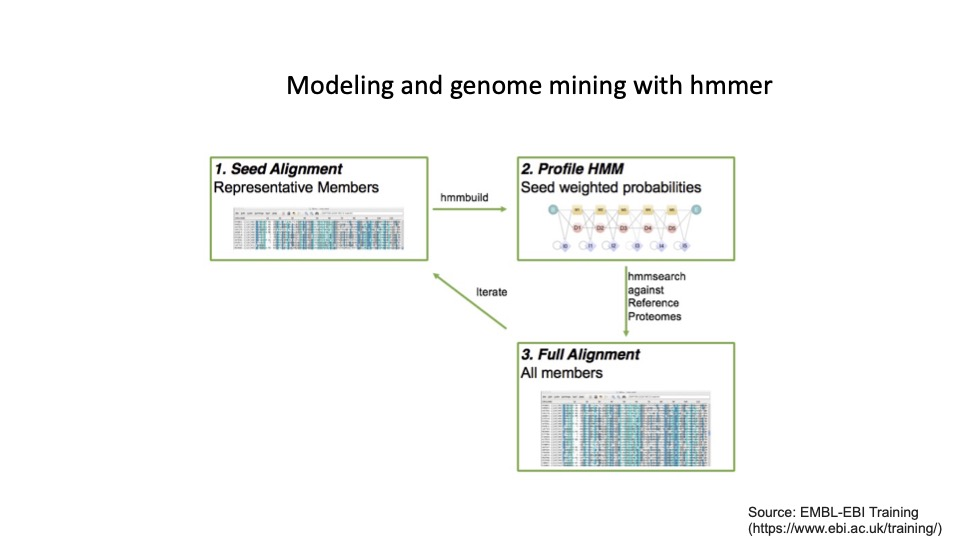

### **Install Resourcers and Tools**

### **Bioconda**
Bioconda lets you install thousands of software packages related to biomedical research using the conda package manager.
https://bioconda.github.io/

### **HMMER**
HMMER is a biological sequence analysis tool using profile hidden Markov models: http://hmmer.org/

### **NCBI Datasets**
A one-stop shop for finding, browsing, and downloading genomic data
https://www.ncbi.nlm.nih.gov/datasets/


### **ncbi-acc-download**
A partner script to the popular ncbi-genome-download script, ncbi-acc-download allows you to download sequences from GenBank/RefSeq by accession through the NCBI ENTREZ API.
https://github.com/kblin/ncbi-acc-download

### **MUSCLE**
MUSCLE (MUltiple Sequence Comparison by Log- Expectation) is a fast and wildly used multiple sequence alignment tool. https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-5-113

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')


!conda install -c bioconda hmmer -y
!conda install -y bioconda::easel

!conda install -y -c conda-forge ncbi-datasets-cli

!pip install ncbi-acc-download

!conda install -y -c bioconda muscle

## **Search and extract effector sequences from proteomes**

#### Non-TAL Effectors From *Xanthomonas oryzae* pv. *oryzae* Suppress Peptidoglycan-Triggered MAPK Activation in Rice

"*Xanthomonas oryzae* pv. *oryzae*, the causal pathogen of bacterial blight of rice, depends on its type III secretion system and associated effector proteins to grow and colonize the vascular tissues of rice plants. The type III effectors include a family of closely related transcription activator-like (TAL) effectors and the rest of diverse effectors, so-called non-TAL effectors. Our understanding of non-TAL effectors for pathogenesis in rice blight is still limited. Here we report a feasible method to rapidly detect the activation of mitogen-activated protein kinase pathway in rice mesophyll protoplasts by the *X. oryzae* pv. *oryzae* derived peptidoglycan and screen for virulent effectors that can suppress the pathogen-associated molecular pattern triggered immunity (PTI) response. Amongst 17 non-TAL effectors transiently expressed in rice cells, we found that three effectors (XopZ, XopN, and XopV) were able to suppress the peptidoglycan-triggered MAPK activation. The triple mutant of the *X. oryzae* pv. *oryzae* strain PXO99A lacking XopZ, XopN, and XopV showed additively reduced virulence. Adding back either of genes restored the virulence of the triple mutant. Our results demonstrate the collective and redundant ability of defense suppression by non-TAL effectors in causing bacterial blight of rice." (Long et al. 2018)

Here we use the XopZ protein as an example to build an effector model and search for homologs in various *Xanthomonas* strains.


#### **Make a hmm profile for XopZ**
The file list_gi contains the Genbank ids of a group of XopZ proteins. The following command will download the proteins listed in the file and save them in XopZ_proteins.pep

In [ ]:
!for x in `cat list_gi`;do ncbi-acc-download -m protein $x;done
!cat [0-9]*.fa > XopZ_proteins.pep
!cat XopZ_proteins.pep

####**Align the protein sequences using MUSCLE**

In [ ]:
!muscle -in XopZ_proteins.pep -out XopZ_aligment.msa
!cat XopZ_aligment.msa

####**Build the HMMER model**

In [ ]:
!hmmbuild xopz_in_house.hmm XopZ_aligment.msa
!cat xopz_in_house.hmm

####**Scan for Xopz homologues in Xanthomonas oryzae* pv *oryzicola Xoc***
Xoc causes bacterial leaf streak of rice
Use the xopz_in_house.hmm to scan and found XopZ homologues in a *Xanthomonas oryzae* pv *oryzicola* proteome.

1- Download the proteome of Xoc deposited in the Genbank

2- Use the hmm model to detect candidate homologs in one selected proteome

3- Use the hmm to detect candidate homologs in all the proteomes

In [ ]:
!datasets download genome taxon "Xanthomonas oryzae pv. oryzicola" --include protein
!unzip ncbi_dataset.zip

In [ ]:
##list the proteomes
!ls ncbi_dataset/data/*/*.faa
!ls ncbi_dataset/data/*/*.faa | wc -l

In [ ]:
##pick one proteome and search
!hmmsearch -o ncbi_dataset/data/GCF_029962345.1/protein.faa_hits xopz_in_house.hmm ncbi_dataset/data/GCF_029962345.1/protein.faa
!cat ncbi_dataset/data/GCF_029962345.1/protein.faa_hits

In [ ]:
##batch search. Mutiple proteome at single time
!for x in `ls ncbi_dataset/data/*/*.faa` ; do echo "Number of detected hits in" $x; hmmsearch xopz_in_house.hmm $x | grep -c ">>"; done
!for x in `ls ncbi_dataset/data/*/*.faa` ; do hmmsearch -o $x"_hits" xopz_in_house.hmm $x ; done

In [ ]:
##for each proteome extract the XopZ homologue
# The esl-sfetch program (in easel/miniapps) is for extracting arbitrary subsets of sequences or subsequences from a sequence file.
!for x in `ls ncbi_dataset/data/*/*.faa` ; do esl-sfetch --index $x ; done
!for x in `ls ncbi_dataset/data/*/*.faa` ; do hmmsearch --tblout xopZ_myhits.tbl xopz_in_house.hmm $x; mv xopZ_myhits.tbl $x"_xopZ_myhits.tbl" ; done
!for x in `ls ncbi_dataset/data/*/*.faa` ; do grep -v "^#" $x"_xopZ_myhits.tbl" | awk '{print $1}' | esl-sfetch -f $x - > $x"_xopZ.fa"; done

Check your results!

**End of the first Case**

## **Search and extract TAL effector sequences from proteomes**
Transcription Activator-Like effectors, also known as TAL effectors, are proteins produced by the bacterial genus *Xanthomonas*. Xanthomonads are a group of Gram-negative bacteria that can cause plant diseases. TAL effectors are key virulence factors employed by xanthomonads to manipulate the host plant's cellular processes and establish infection.

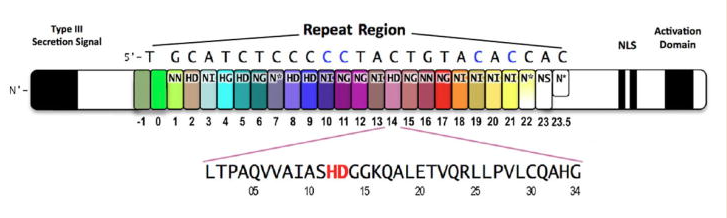.  
Source : Nga-Sze Mak et. al Curr Opin Struct Biol 2013

####**Obtain a HMM profile**
Example TALE protein:
https://www.ebi.ac.uk/interpro/entry/pfam/PF03377/

In [ ]:
##Download a known TAL effector to test your HMM profile.
!ncbi-acc-download -m protein -o tale.fa 1070479254

In [ ]:
##Run the HMM profile and obtain the results.
!hmmsearch -o my_tale.tab PF03377.hmm tale.fa
!cat my_tale.tab
##The following commands report the number of repeats in the TAL effector sequence.
!grep -c "!" my_tale.tab #complete repeats
!grep -c "?" my_tale.tab #truncate repeats

In [ ]:
##Run the HMM profile in a whole proetome.
!hmmsearch -o my_tales.tab PF03377.hmm ncbi_dataset/data/GCF_029962345.1/protein.faa

In [ ]:
#The following command reports the basic stats of the search.
#How many TALEs were found in the proteome?
!grep -c ">>" my_tales.tab

In [ ]:
#The following commands detect the TAL effectors and produce a file myTales_hits.fa . The file contains the protein sequences of all the detected TALEs.
!esl-sfetch --index ncbi_dataset/data/GCF_029962345.1/protein.faa
!hmmsearch --tblout my_tales.tbl PF03377.hmm ncbi_dataset/data/GCF_029962345.1/protein.faa
!grep -v "^#" my_tales.tbl | awk '{print $1}' | esl-sfetch -f ncbi_dataset/data/GCF_029962345.1/protein.faa - > myTales_hits.fa
!cat myTales_hits.fa

In [ ]:
#The following commands detect the TAL effectors and produce a file myTaleshits_repeats.fa . The file will contain the protein sequences of all the detected TALE repeats.
!hmmsearch --domtblout my_tales.dtbl PF03377.hmm ncbi_dataset/data/GCF_029962345.1/protein.faa
!grep -v "^#" my_tales.dtbl | awk '{print $1"/"$20"-"$21, $20, $21, $1}' | esl-sfetch -Cf ncbi_dataset/data/GCF_029962345.1/protein.faa - > myTaleshits_repeats.fa

In [ ]:
##Search TAL effectors in all the Xoc proteomes.
##The following command searches TAL effectors and provides the number of effectors in each proteome.
!for x in `ls ncbi_dataset/data/*/*.faa` ; do echo "number of tales found in" $x; hmmsearch PF03377.hmm $x | grep -c ">>"; done
#!for x in `ls ncbi_dataset/data/*/*.faa` ; do hmmsearch -o $x"_hits" PF03377.hmm $x ; done

In [ ]:
##The following commands report the TALE sequences of all the proteomes . Results will be saved in the file that contains the extension "tales.fa"
!for x in `ls ncbi_dataset/data/*/*.faa` ; do esl-sfetch --index $x ; done
!for x in `ls ncbi_dataset/data/*/*.faa` ; do hmmsearch --tblout myhits2.tbl PF03377.hmm $x; mv myhits2.tbl $x"_myhits2.tbl" ; done
!for x in `ls ncbi_dataset/data/*/*.faa` ; do grep -v "^#" $x"_myhits2.tbl" | awk '{print $1}' | esl-sfetch -f $x - > $x"_tales.fa"; done